In [1]:
import pandas as pd
import quandl
import datetime 
from fredapi import Fred
import numpy as np
import requests
import os
from bs4 import BeautifulSoup
import json
import matplotlib.pyplot as plt


# NYFED: Open market operations

- [PDF link](https://apps.newyorkfed.org/~/media/XML/Schemas/api_spec)
    - Below code is based on page 27

## N.1 Test API

In [2]:
url = 'http://markets.newyorkfed.org/api/tsy/all/results/details/search.json?startdate=01/21/2021&enddate=07/20/2021'

r = requests.get(url)
json_data = json.loads(r.text)

In [3]:
data_dict = {}
for row in json.loads(r.text)['treasury']['auctions']:
    total = row['totalParAmtAccepted']
    date = row['operationDate']
    op_type = row['operationType']
    maturity_start = row['maturityRangeStart']
    maturity_end = row['maturityRangeEnd']
        
    data_dict[date] = np.array([total,op_type, maturity_start, maturity_end])       

In [18]:
df = pd.DataFrame.from_dict(data_dict, orient='index')
df.head(3)

,0,1,2,3
2021-07-20,1199000000,Outright TIPS Purchase,2029-04-15,2051-02-15
2021-07-19,1401000000,Outright Coupon Purchase,2036-02-15,2043-11-15
2021-07-16,3201000000,Outright Coupon Purchase,2028-08-15,2031-05-15


In [5]:
df.iloc[:, 1].unique()

array(['Outright TIPS Purchase', 'Outright Coupon Purchase',
       'Outright FRN Sale'], dtype=object)

## N.2 Create function

In [6]:
def data_fedny(op, rep_type, format_file, start, end):
    url = "https://markets.newyorkfed.org/api/tsy/{}/results/{}/search.{}?startdate={}&enddate={}".format(
        op, 
        rep_type, 
        format_file,
        start,
        end)
    
    r = requests.get(url)
    
    #"""
    data_dict = {}
    for row in json.loads(r.text)['treasury']['auctions']:
        total = row['totalParAmtAccepted']
        date = row['operationDate']
        op_type = row['operationType']
        maturity_start = row['maturityRangeStart']
        maturity_end = row['maturityRangeEnd']

        data_dict[date] = np.array([total,op_type, maturity_start, maturity_end])       
    
    df = pd.DataFrame.from_dict(data_dict, orient='index')
    #"""
    
    return df

In [19]:
df = data_fedny('purchases', #all, sales, purchases
           'summary', # summary, details
           'json', #csv,xlsx,xml,json
           '01/01/2020', #start
           '02/20/2022' #end
          )
df.head(2)

,0,1,2,3
2022-02-15,3201000000,Outright Coupon Purchase,2026-08-31,2029-02-15
2022-02-10,3201000000,Outright Coupon Purchase,2029-02-15,2031-11-15


In [20]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 462 entries, 2022-02-15 to 2020-01-02
Columns: 4 entries, 0 to 3
dtypes: object(4)
memory usage: 18.0+ KB


## N.3 Clean data

In [21]:
df.columns = ['total_purchases', 'type', 'maturity_shortest','maturity_longest']
df.index = pd.to_datetime(df.index)
df.head(2)

,total_purchases,type,maturity_shortest,maturity_longest
2022-02-15,3201000000,Outright Coupon Purchase,2026-08-31,2029-02-15
2022-02-10,3201000000,Outright Coupon Purchase,2029-02-15,2031-11-15


In [22]:
name_old = df.type.unique().tolist()
name_new = ['TIPS', 'Coupons', 'FRN',' Bills']
df.type = df.type.map(dict(zip(name_old, name_new)))
df.type.unique()

array(['TIPS', 'Coupons', 'FRN', ' Bills'], dtype=object)

In [23]:
df.total_purchases = df.total_purchases.apply(float)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 462 entries, 2022-02-15 to 2020-01-02
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total_purchases    462 non-null    float64
 1   type               462 non-null    object 
 2   maturity_shortest  462 non-null    object 
 3   maturity_longest   462 non-null    object 
dtypes: float64(1), object(3)
memory usage: 18.0+ KB


## N.4 Plot

In [25]:
df_data = df[['total_purchases','type']].reset_index().pivot_table(
    index='index',columns='type')
df_data.columns = df_data.columns.droplevel(0)
df_data = df_data.divide(1000000000).astype(float)
df_data.head(2)

type,Bills,Coupons,FRN,TIPS
index,,,,
2020-01-02,NaN,NaN,NaN,2.399
2020-01-03,7.501,NaN,NaN,NaN


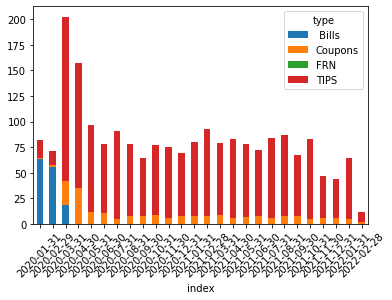

In [26]:
df_monthly = df_data.resample('M').sum()
ax = df_monthly.plot(kind='bar', stacked=True)
ticks = [x.strftime('%Y-%m-%d') for x in df_monthly.index]
ax.set_xticklabels(ticks, rotation=45);

Text(0.5, 1.0, '')

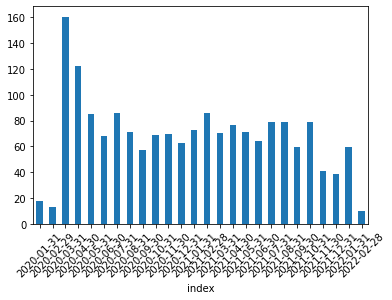

In [27]:
ax = df_monthly.TIPS.plot(kind='bar', stacked=True)
ticks = [x.strftime('%Y-%m-%d') for x in df_monthly.index]
ax.set_xticklabels(ticks, rotation=45)
plt.title('')